In [8]:
# Importing Juliet, a tool for modeling exoplanet transit data.
# Juliet helps analyze light curves and extract planetary parameters using various statistical methods.
import juliet  

# Importing standard Python libraries for interacting with the operating system, system-specific parameters, and serialization.
import os
import sys
import pickle

# Importing Sympy, a library for symbolic mathematics in Python.
from sympy import *

# Importing additional modules and packages for numerical computations and data visualization.
from numpy import *
from tabulate import tabulate
from colorama import*
from matplotlib.offsetbox import*

# Redundant import of numpy and matplotlib.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define a font configuration for Matplotlib plots.
# This configuration can be used to customize the appearance of plot text.
font1 = {'family': 'serif', 'color': 'black'}


In [9]:
# The TOI (TESS Object of Interest) ID is used to identify exoplanet candidates.

Target_Star = 'TOI 1011'  # Define the name of the target star

# -------------------------------------------------
# User-defined inputs for the host star and transit parameters to define characteristics and other initial conditions.
# -------------------------------------------------

magnitude, mag_err = [8.2388, 0.006]  # Apparent magnitude and its uncertainty.
mass_of_the_host_star_in_solar_masses, m_err = [0.94, 0.119244]  # Star's mass in solar masses and its uncertainty.
radius_of_the_host_star_in_solar_radius, r_err = [0.941335, 0.0546131]  # Star's radius in solar radius and its uncertainty.
temperature_of_the_host_star, t_err = [5413.68, 132.798]  # Star's temperature in Kelvin and its uncertainty.
luminosity, l_err = [0.6857309, 0.0160353]  # Star's luminosity and its uncertainty.

# Transit parameters
Period, Period_Deviation = [2.4704981, 0.0000073]  # Orbital period and its deviation.
Time, Time_Deviation = [2457000 + 2231.1309, 0.0031]  # Transit time and its deviation.
a_lower, a_upper = [1, 35]  # Lower and upper bounds for a uniform distribution.

# Define file paths and output folders
filename = 'Detrended & Combined Lightcurves/Combined TOI ' + Target_Star[4:] + '.fits'  # Path to the transit data file.
output_folder = 'TOI_' + Target_Star[4:] + '_Global_Fit'  # Folder to save results.

# ---------------------------------------------------------------------------------------------------------
# Define prior distributions for various parameters used in transit modeling.
# ---------------------------------------------------------------------------------------------------------

# The Espinoza (2018) parametrization for the ratio of planet radius to star radius (Rp/Rs) and the impact parameter.
# Uniform distribution is suggested for parameters that should fit within a specific range.
# The Kipping parametrization for limb darkening (LD) uses two parameters; uniform distribution is recommended.
# Fixed values for eccentricity and argument of periastron (eccentricity is 0, and argument of periastron is 90 degrees).

# ---------------------------------------------------------------------------------------------------------

# Define the master prior dictionary and specify the distribution types for each parameter.
priors = {}

# List of parameter names to fit during modeling:
params = ['P_p1', 't0_p1', 'r1_p1', 'r2_p1', 'q1_TESS', 'q2_TESS', 'a_p1', 'mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS', 'ecc_p1', 'omega_p1', 'GP_sigma_TESS', 'GP_rho_TESS']

# Specify the distribution type for each parameter:
dists = ['normal', 'normal', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'fixed', 'normal', 'loguniform', 'fixed', 'fixed', 'loguniform', 'loguniform']

# Define hyperparameters for each distribution:
hyperps = [[Period, Period_Deviation], [Time, Time_Deviation], [0, 1], [0, 1], [0, 1], [0, 1], [a_lower, a_upper], 1.0, [0, 0.1], [0.1, 1000], 0, 90, [1e-6, 1e6], [1e-3, 1e3]]

# Populate the priors dictionary with parameter names, distribution types, and hyperparameters.
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp  # Assign the distribution and hyperparameters.


### Transit Modelling

In [ ]:
# Get the TESS photometric data from the specified FITS file.
# Extract time, flux, and flux error data for transit analysis.
t, f, ferr = juliet.get_TESS_data(filename)

# Organize the extracted data into dictionaries.
# Convert TESS JD (Julian Date) to JD for easier manipulation and storage.
times, fluxes, fluxes_error = {}, {}, {} 
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t + 2457000, f, ferr 

# Load RV (radial velocity) data and setup the Juliet dataset with the given priors and light curve data.
# Juliet uses these inputs to model exoplanet transits and determine parameters like orbital period, radius, and others.
dataset = juliet.load(
    priors=priors,  # Pass the priors dictionary containing the distribution and hyperparameters for various transit parameters.
    t_lc=times,  # Set the light curve times.
    y_lc=fluxes,  # Set the light curve fluxes.
    yerr_lc=fluxes_error,  # Set the light curve flux errors.
    GP_regressors_lc=times,  # Gaussian Process regressors for the light curve (typically the times).
    out_folder=output_folder  # Specify the output folder where results will be stored.
)

# Fit the dataset using the specified sampling parameters.
# This step runs the fitting process to model the transit data and estimate exoplanet characteristics.
results = dataset.fit(
    sampler='dynesty',  # Specify the sampling algorithm for fitting 
    n_live_points=500,  # Number of live points for the sampler.
    nwalkers=100000,  # Number of walkers (used for MCMC methods).
    nsteps=300000,  # Number of steps for the fitting process.
    nburnin=500000,  # Number of burn-in steps to reach a steady state.
    emcee_factor=0.0001,  # Scaling factor for the emcee sampler.
    ecclim=1.0,  # Eccentricity limit (1.0 means circular orbit).
    pl=0.0,  # Lower bound for the prior distribution.
    pu=1.0,  # Upper bound for the prior distribution.
    ta=2457000.0,  # TESS Julian Date offset for normalization.
    nthreads=None,  # Number of threads to use (None uses all available threads).
    dynamic=True,  # Enable dynamic sampling with Dynesty.
    dynesty_bound='multi',  # Set the bounding method for Dynesty.
    dynesty_sample='rwalk',  # Set the sampling method for Dynesty.
    dynesty_nthreads=None,  # Number of threads for Dynesty.
    dynesty_n_effective=np.inf,  # Effective sample size for stopping condition.
    dynesty_use_stop=True,  # Enable stopping condition for Dynesty.
    dynesty_use_pool=None  # Use a processing pool for parallelization.
)

12260it [1:32:59,  1.97it/s, bound: 142 | nc: 31 | ncall: 342028 | eff(%):  3.585 | loglstar:   -inf < 208817.541 <    inf | logz: 208791.825 +/-    nan | dlogz: 32.203 >  0.509]

(0.997, 1.003)

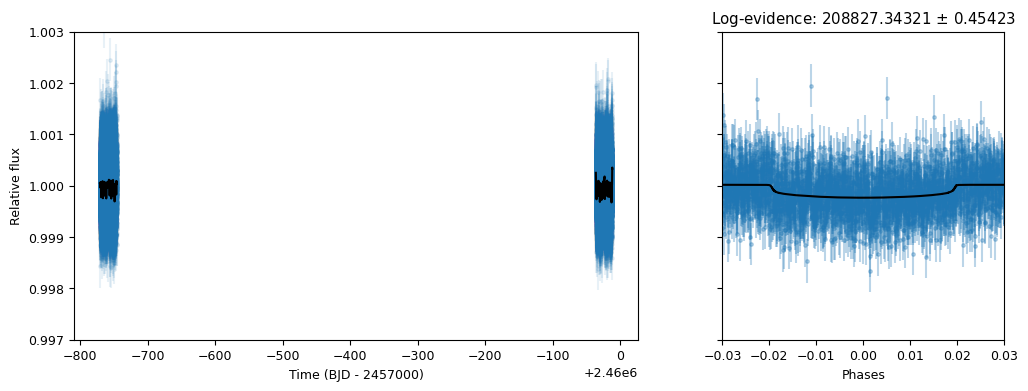

In [6]:
# Importing GridSpec from Matplotlib to create subplots with custom layouts.
import matplotlib.gridspec as gridspec

# Get the median values for the orbital period and transit time from the fitted results.
# These will be used to calculate the phase of the light curve.
P, t0 = np.median(results.posteriors['posterior_samples']['P_p1']), \np.median(results.posteriors['posterior_samples']['t0_p1'])

# ------------------------------------------------------------------------------------------
# Define plot, calculate phases, plot the observed data, and best-fit model
# ------------------------------------------------------------------------------------------
# Calculate the phases for the light curve based on the orbital period and transit time.
# This helps in plotting the phase-folded light curve, making transits more apparent.

phases = juliet.get_phases(dataset.times_lc['TESS'], P, t0)  # Calculate the phase for each time point in the light curve.
idx = np.argsort(phases)  # Sort the phases for plotting.

# Extract the full model (transit plus Gaussian Process) from the fitted results.
transit_plus_GP_model = results.lc.evaluate('TESS')  # The full model includes both the transit and GP components.

# Extract the deterministic part of the model (the transit-only model).
# This is the transit curve without the Gaussian Process, useful for visualizing the transit alone.
transit_model = results.lc.model['TESS']['deterministic']  # The deterministic part represents the expected transit.

# Extract the Gaussian Process (GP) part of the model.
# The GP part accounts for trends in the data, providing a smoother fit.
gp_model = results.lc.model['TESS']['GP']  # The GP part captures systematic trends in the light curve.

# Now set up the plot structure and plot the data and models:
fig = plt.figure(figsize=(12, 4))  # Create a figure with specified size.
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1])  # Create a grid layout with two columns.
ax1 = plt.subplot(gs[0])  # First subplot for the full light curve plot.

# Plot the observed data with error bars.
ax1.errorbar(dataset.times_lc['TESS'], dataset.data_lc['TESS'], \ yerr=dataset.errors_lc['TESS'], fmt='.', alpha=0.1)

# Plot the full model (transit plus Gaussian Process).
ax1.plot(dataset.times_lc['TESS'], transit_plus_GP_model, color='black', zorder=10) 

# Adjust plot limits and labels.
# Set the y-axis limits to focus on the transit area and the x-axis label for time.
ax1.set_ylim([0.997, 1.003])  # Adjust the y-axis to focus on variations in flux.
ax1.set_xlabel('Time (BJD - 2457000)')  # Label the x-axis with time (Barycentric Julian Date).
ax1.set_ylabel('Relative flux')  # Label the y-axis with relative flux.

# Second subplot for the phase-folded light curve:
ax2 = plt.subplot(gs[1])  # Second subplot for the phase-folded plot.
ax2.set_title('Log-evidence: {0:.5f} $\pm$ {1:.5f}'.format(results.posteriors['lnZ'], results.posteriors['lnZerr']))  # Title with log-evidence.

# Plot the phase-folded light curve with the GP part removed.
# This helps to visualize the transit alone without systematic noise.
ax2.errorbar(phases, dataset.data_lc['TESS'] - gp_model, \yerr=dataset.errors_lc['TESS'], fmt='.', alpha=0.3) 

# Plot the transit-only model (divided by mflux) to compare with the phase-folded data.
ax2.plot(phases[idx], transit_model[idx], color='black', zorder=10)  # Plot the transit model.
ax2.yaxis.set_major_formatter(plt.NullFormatter())  # Hide the y-axis major ticks (for cleaner visualization).
ax2.set_xlabel('Phases')  # Label the x-axis with phases.
ax2.set_xlim([-0.03, 0.03])  # Set the x-axis limits to focus on the transit area.
ax2.set_ylim([0.997, 1.003])  # Set the y-axis limits to focus on transit variations.


In [7]:
# Initialize empty lists to store filtered elements from the light curve.
# These lists will contain only the data points within a specific range of phases.
filtered_Phases = []  # To store the filtered phases.
filtered_flux = []  # To store the corresponding flux values.
filtered_yerr = []  # To store the associated error values.

# This variable isn't used in the loop; it might have been intended for another operation.
filtered_data_2d_array = []  # An empty list for a possible 2D array of filtered data.

# Iterate through the phase, flux, and error arrays simultaneously using a for loop.
# This allows us to filter the data based on the specified phase range.
for phase, flux, yerr in zip(phases, (dataset.data_lc['TESS'] - gp_model), (dataset.errors_lc['TESS'])):
    if -0.025 <= phase <= 0.025:  # Define the phase range to filter the data.
        # Append the elements to the filtered lists if they fall within the defined range.
        filtered_Phases.append(phase)  # Append the phase to the filtered list.
        filtered_flux.append(flux)  # Append the flux to the filtered list.
        filtered_yerr.append(yerr)  # Append the error to the filtered list.

In [8]:
# Combine the filtered lists into a single list of tuples.
combined_columns = list(zip(filtered_Phases, filtered_flux, filtered_yerr))

0.01

In [9]:
import csv

# Define the name of the CSV file where the combined data will be saved.
csv_file = "TOI_1011_combined_data_triceratops.csv"  # Name the output CSV file.

# Open the CSV file in write mode.

with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(combined_columns)  # Write all combined columns as rows in the CSV file.

Data has been saved to TOI_1011_combined_data_triceratops.csv


### Transit Lightcurve

##### 1. Evaluating the Model

In [10]:
# Evaluate the transit model for the TESS light curve.
# This step generates the expected light curve based on the best-fit transit model, allowing you to compare it with observed data.
transit_model = results.lc.evaluate('TESS')

# Get the period and time of transit center.
P, t0 = np.median(results.posteriors['posterior_samples']['P_p1']), \np.median(results.posteriors['posterior_samples']['t0_p1'])


phases0 = juliet.get_phases(dataset.times_lc['TESS'], P, t0)  # Calculate the phases for the light curve based on the period and transit time.
idx0 = np.argsort(phases0)  # Sort the phases for easier plotting.

# Bin the data to create a smoother representation of the light curve.
# Binning combines multiple data points into larger groups to reduce noise and improve visualization.
p_bin, y_bin, yerr_bin = juliet.bin_data(phases0[idx0], dataset.data_lc['TESS'][idx0], 100)  # Bin the original light curve data with 100 bins.
p_bin1, y_bin1, yerr_bin1 = juliet.bin_data(phases0[idx0], dataset.data_lc['TESS'][idx0] - transit_model[idx0], 100)  # Bin the data with the transit model removed.


##### 2. Plotting the Model & Data

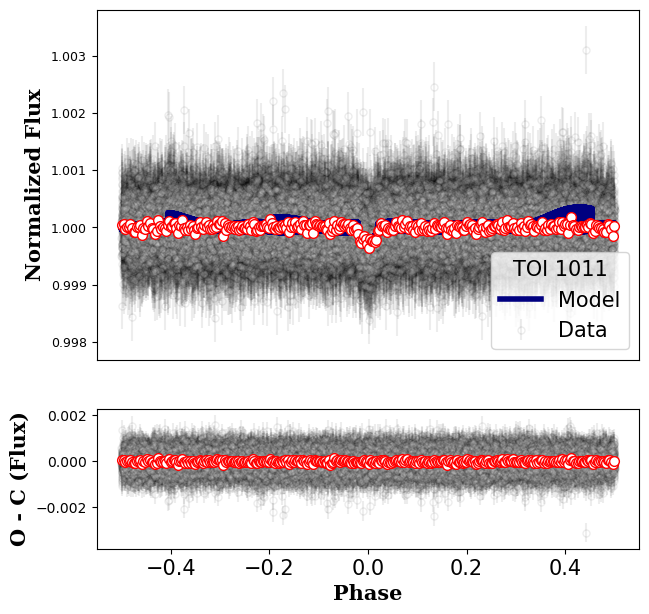

In [11]:
f, (f1, f2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 2]})  # Two subplots with a 5:2 height ratio.
f.set_size_inches(7, 7)  # Set the figure size to 7x7 inches.


# Plot the entire light curve data with error bars.
f1.errorbar(
    phases0, dataset.data_lc['TESS'], yerr=dataset.errors_lc['TESS'], fmt='ko', mfc='white', markersize=5, 
    alpha=0.07, zorder=1, label="Data") 

# Plot the best-fit transit model on top of the data.
f1.plot(phases0[idx0], transit_model[idx0], color='navy', lw=4, zorder=2, label="Model")

# Plot the binned data for reference (to smooth out the noise).
f1.errorbar(p_bin, y_bin, yerr=yerr_bin, fmt='ro', mfc='white', markersize=7, zorder=3)

# Set plot labels and add a legend.
f1.set_ylabel('Normalized Flux', fontdict=font1, weight="bold", fontsize="15") 
f1.legend(title=Target_Star, loc="lower right", fontsize=15, title_fontsize=15) 

f1.set_xticks([])  # Hide x-axis ticks.
plt.yticks(fontsize=15)  # Set y-axis tick font size.


# Plot the residuals (difference between the transit model and the observed data).
f2.errorbar(
    phases0, transit_model - dataset.data_lc['TESS'], yerr=dataset.errors_lc['TESS'], fmt='ko', 
    mfc='white', markersize=5, alpha=0.07, zorder=1) 

# Plot a zero line to represent the expected transit model.
f2.plot(phases0, np.zeros(np.size(phases0)), color='navy', lw=4, zorder=2)

# Plot the binned residual data.
f2.errorbar(p_bin1, y_bin1, yerr=yerr_bin1, fmt='ro', mfc='white', markersize=7, zorder=3)

# Set plot labels and ticks for the residual plot.
f2.set_xlabel('Phase', fontdict=font1, weight="bold", fontsize="15") 
f2.set_ylabel('O - C (Flux)', fontdict=font1, weight="bold", fontsize="15")

plt.xticks(fontsize=15)  # Set x-axis tick font size.
plt.yticks(fontsize=10)  # Set y-axis tick font size.


# Save the plot to the output folder in JPEG format.

f.savefig(
    os.path.join(output_folder, 'TOI_' + Target_Star[4:] + '_Transit.jpeg'), 
    format='jpeg', dpi=600, bbox_inches='tight') 


### Output File

In [12]:
# Set the paths for different output files.
dat_file = 'TOI_' + Target_Star[4:] + '_Global_Fit/posteriors.dat'  # Path for storing posterior data.
parafile = 'TOI_' + Target_Star[4:] + '_Global_Fit/Parameters.txt'  # Path for parameter data in text format.
latexfile = 'TOI_' + Target_Star[4:] + '_Global_Fit/Latex_TOI_' + Target_Star[4:] + '.tex'  # Path for LaTeX file.

# Read the posterior data from the specified DAT file.
dat_excel = pd.read_table(dat_file)

# Convert the DataFrame to an Excel file and save it.
my_xlsx = dat_excel.to_excel('TOI_' + Target_Star[4:] + '_Global_Fit/Parameters.xlsx')

# Read the Excel file to extract specific data.
op_data = pd.read_excel('TOI_' + Target_Star[4:] + '_Global_Fit/Parameters.xlsx')

# Extract specific values from the reloaded Excel data.
# This step retrieves the median, upper error, and lower error for certain parameters.
median_val = op_data[op_data.columns.values[3]] 
upper_err = op_data[op_data.columns.values[5]]
lower_err = op_data[op_data.columns.values[7]] 


### Calculation of Planetary Parameters

##### 1. Constants & Conversions

In [14]:
# ----------------------------------------------------------------------------------------------
# Define Constants
# ----------------------------------------------------------------------------------------------

PI = np.pi                 # pi
G = 6.67*10**(-11)         # Gravitational Constant
AU = 1.496*10**(11)        # Astronomical Unit
M_S = 1.989*10**(30)       # Solar Mass
M_J = 1.898*10**(27)       # Jupiter Mass
M_E = 5.97219*10**(24)     # Earth Mass

R_S = 6.9634*10**(8)       # Solar Radius
R_J = 6.9911*10**(7)       # Jupiter Radius
R_E = 6371000              # Earth Radius
 

# Conversions
d2s = 24*3600              # Days to Seconds (for orbital period)
d2r = PI/180               # Degree to Radian (for inclination angle and Argument of Periastron)
rjtore = R_J/R_E           # Convert Jupiter Radius to Earth Radius
jmtoem = M_J/M_E           # Convert Jupiter mass to Earth mass

##### 2. Planetary Parameters obtained from the Juliet Run

In [15]:
# Convert the mass of the host star from solar masses to kilograms.
m1 = mass_of_the_host_star_in_solar_masses * M_S 

# Convert the radius of the host star from solar radius to meters.
r1 = radius_of_the_host_star_in_solar_radius * R_S

# Extract the temperature of the host star.
T1 = temperature_of_the_host_star

# -------------------------------------------------------------------------------------------
# Convert and extract key parameters for the exoplanet.
# -------------------------------------------------------------------------------------------

# Calculate the orbital period in seconds.
P, Pu, Pl = [median_val[0] * d2s, upper_err[0] * d2s, lower_err[0] * d2s] 

# Extract the orbital semi-major axis.
ars, arsu, arsl = [median_val[9], upper_err[9], lower_err[9]]

# Extract the epoch time.
t0, t0u, t0l = [median_val[1], upper_err[1], lower_err[1]]

# Extract the fractional radius (planet radius to star radius ratio).
rprs, rprsu, rprsl = [median_val[4], upper_err[4], lower_err[4]]

# Extract the impact parameter, indicating how centrally the planet transits the star.
b, bu, bl = [median_val[5], upper_err[5], lower_err[5]].

# Convert the inclination angle from degrees to radians.
i, iu, il = [median_val[6] * d2r, upper_err[6] * d2r, lower_err[6] * d2r]

##### 3. Calculation of rest of the parameters

In [16]:
# ---------------------------------------------------------------------------------------------
# Calculate additional exoplanet parameters like transit depth, radius, semi-major axis, etc.
# ---------------------------------------------------------------------------------------------

# Transit depth is the fraction of the star's light blocked by the planet during transit.
delta = rprs**2  
deltau = rprsu * 2 / rprs  # Upper uncertainty for transit depth.
deltal = rprsl * 2 / rprs  # Lower uncertainty for transit depth.

# ---------------------------------------------------------------------------------------------
# Calculate the radius of the exoplanet.
# ---------------------------------------------------------------------------------------------

# Radius is derived from the fractional radius (Rp/Rs) and the radius of the host star.
Rp = rprs * r1
Rpu = rprsu / rprs  # Upper uncertainty for the radius.
Rpl = rprs / rprs  # Lower uncertainty for the radius.

# ---------------------------------------------------------------------------------------------
# Calculate the semi-major axis of the exoplanet's orbit.
# ---------------------------------------------------------------------------------------------

# Semi-major axis is derived from the fractional semi-major axis and the radius of the host star.
a = ars * r1 
au = arsu / ars  # Upper uncertainty for the semi-major axis.
al = arsl / ars  # Lower uncertainty for the semi-major axis.

# ---------------------------------------------------------------------------------------------
# Calculate the equilibrium temperature of the exoplanet.
# ---------------------------------------------------------------------------------------------

# Equilibrium temperature represents the expected temperature based on the host star's temperature and the planet's distance.
Teq = T1 * np.sqrt(r1 / (2 * a)) 
Tequ = T1 * np.sqrt(r1 / (2 * (a - al))) - Teq  # Upper uncertainty for equilibrium temperature.
Teql = Teq - T1 * np.sqrt(r1 / (2 * (a + au)))  # Lower uncertainty for equilibrium temperature.

# ---------------------------------------------------------------------------------------------
# Calculate the transit duration.
# ---------------------------------------------------------------------------------------------

# Transit duration is the time taken for the planet to cross the star, depending on orbital characteristics and impact parameter.
Td = (P / PI) * np.arcsin(np.sqrt(1 + rprs - b ** 2) / (np.sqrt(1 - (np.cos(i)) ** 2) * ars))
Tdu = ((P - Pl) / PI) * np.arcsin(np.sqrt(1 + rprs - rprsl - (b - bl) ** 2) / (np.sqrt(1 - (np.cos(i - il)) ** 2) * (ars - arsl))) - Td  # Upper uncertainty.
Tdl = Td - ((P + Pu) / PI) * np.arcsin(np.sqrt(1 + rprs + rprsu - (b + bu) ** 2) / (np.sqrt(1 - (np.cos(i + iu)) ** 2) * (ars + arsu)))  # Lower uncertainty.

# ---------------------------------------------------------------------------------------------
# Calculate the insolation flux.
# ---------------------------------------------------------------------------------------------

# Insolation flux represents the energy received by the planet from its host star, depending on the distance and luminosity.
S = luminosity * (AU / a) ** 2 
Su = (luminosity + l_err) * (AU / (a - al)) ** 2 - S  # Upper uncertainty for insolation flux.
Sl = S - (luminosity - l_err) * (AU / (a + au)) ** 2  # Lower uncertainty for insolation flux.


##### 4. Limb Darkening Parameters

In [17]:
# -------------------------------------------------------------------------------------------
# Limb darkening parameters and their transformation.
# -------------------------------------------------------------------------------------------

# Retrieve the posterior samples for limb darkening parameters q1 and q2 from the results.
# q1 and q2 are limb darkening coefficients for the TESS instrument, following the Kipping parametrization.
q1, q2 = results.posteriors['posterior_samples']['q1_TESS'], \results.posteriors['posterior_samples']['q2_TESS'] 

# Transform q1 and q2 back to the limb darkening coefficients u1 and u2.
# Limb darkening describes how the brightness of a star varies from its center to its edge (limb).
u1, u2 = juliet.utils.reverse_ld_coeffs('quadratic', q1, q2)

# Plot the medians and errors for u1 and u2 from the posterior.
u1m, u1u, u1l = juliet.utils.get_quantiles(u1)
u2m, u2u, u2l = juliet.utils.get_quantiles(u2)


### Visualization of Planetary System

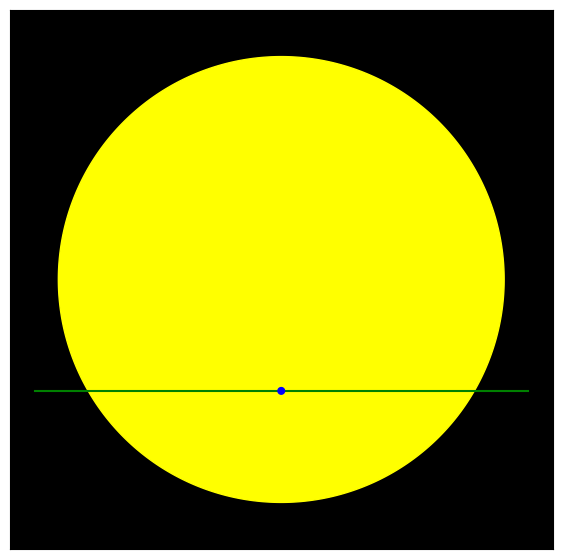

In [19]:
# ---------------------------------------------------------------------------------------------
# Create visual representations of the target star and planet, with a focus on their radii, inclination angle, and other related parameters.
# ---------------------------------------------------------------------------------------------

# Generate an array of angles from 0 to 2π for drawing circles (representing star and planet).
theta = np.linspace(0, 2 * PI, 1000)

# Get the target star radius in solar radius and planet radius in solar radius.
target_star_radii = radius_of_the_host_star_in_solar_radius
planet_radii = Rp / R_S 

# Determine the brightness temperature of the target star.
temp = temperature_of_the_host_star

# Adjust the impact parameter's sign based on the inclination angle.
if i * 180 / PI > 90:
    b = -b  # Flip the sign of the impact parameter if the inclination is greater than 90 degrees.

# Calculate the x and y coordinates for the star and planet (for plotting the circles).
x = target_star_radii * np.sin(theta)
y = target_star_radii * np.cos(theta)

x1 = planet_radii * np.sin(theta)  # X-coordinates for the planet's edge.
y1 = planet_radii * np.cos(theta) - b * target_star_radii  # Y-coordinates for the planet, adjusted by the impact parameter.

# Create a horizontal line indicating the transit path.
xline = np.linspace(-(max(x) + 0.1), (max(x) + 0.1), 100) 
yline = -b * target_star_radii * np.ones(np.size(xline))

# Determine the color of the star based on its temperature.

if temp > 30000:
    col = 'paleturquoise'  # Very hot stars.
elif (temp > 10000) & (temp <= 30000):
    col = 'azure'  # Hot stars.
elif (temp > 7500) & (temp <= 10000):
    col = 'white'  # Bright white stars.
elif (temp > 6000) & (temp <= 7500):
    col = 'lightyellow'  # Yellow stars.
elif (temp > 5200) & (temp <= 6000):
    col = 'yellow'  # Sun-like stars.
elif (temp > 3700) & (temp <= 5200):
    col = 'coral'  # Cooler stars.
elif (temp > 2400) & (temp <= 3700):
    col = 'tomato'  # Coolest stars.
else:
    col = 'red'  # Very cool stars.

# Plot the star and planet with the determined colors.
plt.fill(x, y, zorder=1, c=col)  # Plot the star.
plt.fill(x1, y1, zorder=3, c='b')  # Plot the planet.
plt.plot(xline, yline, zorder=2, c='green')  # Plot the transit path.

plt.axis('equal')  # Ensure the plot maintains equal axis scaling for correct proportions.

# Set the plot's background color to black for contrast.
plt.gca().set_facecolor('k')
plt.tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

# Adjust the plot size.
fig = plt.gcf()
fig.set_size_inches(7, 7)  # Set the figure size to 7x7 inches.

# Save the plot to a JPEG file with high resolution.
fig.savefig(
    os.path.join(output_folder, 'TOI_' + Target_Star[4:] + '_Visuals.jpeg'), 
    format='jpeg', dpi=600, bbox_inches='tight')  


### LaTeX Script 

In [20]:
with open(latexfile, "w") as latex:
    print("\\documentclass[12pt, a4paper]{book}", file = latex)
    
    print("\\usepackage{amsmath}", file = latex)
    print("\\usepackage{geometry}", file = latex)
    print("\\usepackage{graphicx}", file = latex)
    print("\\usepackage{xurl}", file = latex)
    print("\\geometry{paper=a4paper, top=3cm, bottom=3cm, left=2.6cm, right=2.6cm,", \
           "headheight=14pt,footskip=1.4cm, headsep=10pt}", file = latex)
    
    print(" ", file = latex)
    
    print("\\begin{document}", file = latex)
    
    print(" ", file = latex)
    
    print("\\begin{center}", file = latex)
    print("{\\Huge \\textbf{Modelling Transit Light Curve through \\texttt{Juliet}}}\\\\", file = latex)
    print("\\vspace*{1cm}", file = latex)
    print("{\\Huge \\textbf{",Target_Star,"}}", file = latex)
    print("\\end{center}", file = latex)
    
    print(" ", file = latex)
    print("\\vspace*{0.6cm}", file = latex)
    print(" ", file = latex)
    
    print("\\begin{center}", file = latex)
    print("\\includegraphics[scale=0.5]{TOI_"+Target_Star[4:]+"_Visuals}", file = latex)
    print("\\end{center}", file = latex) 
    
    print(" ", file = latex)
    print("\\vspace*{0.6cm}", file = latex)
    print(" ", file = latex)
    
    print("\\begin{center}", file = latex)
    print("\\includegraphics[scale=0.6]{TOI_"+Target_Star[4:]+"_Transit}", file = latex)
    print("\\end{center}", file = latex)
    
    print(" ", file = latex)
    
    print("\\newpage", file = latex) 
    print("\\begin{center}", file = latex)
    print("{\\large \\textbf{Stellar Parameters}}", file = latex)
    print("\\end{center}", file = latex)
    print("\\begin{itemize}", file = latex)
    print("\\item Magnitude (V) : ", magnitude, "$\pm$", mag_err, file = latex)
    print("\\item Mass of the Star ($M_*$) : ", mass_of_the_host_star_in_solar_masses, "$\pm$", m_err, "$M_\odot$", file = latex)
    print("\\item Radius of the Star ($R_*$) : ", radius_of_the_host_star_in_solar_radius, "$\pm$", r_err, "$R_\odot$", file = latex)
    print("\\item Temperature (T) : ", temperature_of_the_host_star, "$\pm$", t_err, "K", file = latex)
    print("\\item Luminosity (L) : ", luminosity, "$\pm$", l_err, "$L_\odot$", file = latex)
    print("\\end{itemize}", file = latex)

    print("\\vspace*{0.6cm}", file = latex)
    print("\\begin{center}", file = latex)
    print("{\\large \\textbf{Median values and 68\\% confidence interval from \\texttt{Juliet}}}", file = latex)
    print("\\end{center}", file = latex)
    
    print(" ", file = latex)
    
    print("\\begin{center}", file = latex)
    print("\\begin{tabular}{c c c}", file = latex)

    print("\hline", file = latex)
    print("\hline", file = latex)
    
    print("Parameters &","Description (Unit) &","Values \\\\", file = latex)
    print("\hline", file = latex)

    print(" & & \\\\", file = latex)
    print("P &","Period (days) &",f"{P/d2s:0.6f}","$^{+",f"{Pu/d2s:0.6f}","} _{-",f"{Pl/d2s:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$R_P$ &","Radius ($R_J$) &",f"{Rp/R_J:0.6f}","$^{+",f"{Rpu/R_J:0.6f}","} _{-",f"{Rpl/R_J:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$R_P$ &","Radius ($R_E$) &",f"{Rp/R_E:0.6f}","$^{+",f"{Rpu/R_E:0.6f}","} _{-",f"{Rpl/R_E:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$T_C$ &","Epoch Time (BJD) &",f"{t0:0.6f}","$^{+",f"{t0u:0.6f}","} _{-",f"{t0l:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$T_d$ &","Transit Duration (days) &",f"{Td/(3600*24):0.6f}","$^{+",f"{Tdu/(3600*24):0.6f}", \
          "} _{-",f"{Tdl/(3600*24):0.6f}","}$ \\\\", file = latex)
    
    print(" & & \\\\", file = latex)
    print("$a$ &","Semi-major Axis (AU) &",f"{a/AU:0.6f}","$^{+",f"{au/AU:0.6f}","} _{-",f"{al/AU:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$i$ &","Inclination (Degree) &",f"{i*180/PI:0.6f}","$^{+",f"{iu*180/PI:0.6f}","} _{-",f"{il*180/PI:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$e$ &","Eccentricity &","0 (Fixed) \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$\omega$ &","Argument of Periastron (Degree) &","90 (Fixed) \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$T_{eqq}$ &","Equilibrium Temperature (K) &",f"{Teq:0.6f}","$^{+",f"{Tequ:0.6f}","} _{-",f"{Teql:0.6f}","}$ \\\\", file = latex)
    
    print(" & & \\\\", file = latex)
    print("$S$ &","Insolation ($S_E$) &",f"{S:0.6f}","$^{+",f"{Su:0.6f}","} _{-",f"{Sl:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$R_P/R_S$ &","Radius of planet in stellar radii &",f"{rprs:0.6f}","$^{+",f"{rprsu:0.6f}", \
          "} _{-",f"{rprsl:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$a/R_S$ &","Semi-major axis in stellar radii &",f"{ars:0.6f}","$^{+",f"{arsu:0.6f}","} _{-",f"{arsl:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$\delta$ &","Transit Depth (Fraction) &",f"{delta:0.6f}","$^{+",f"{deltau:0.6f}","} _{-",f"{deltal:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$b$ &","Impact Parameter &",f"{b:0.6f}","$^{+",f"{bu:0.6f}","} _{-",f"{bl:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$u_1$ &","Limb Darkening Parameter &",f"{u1m:0.6f}","$^{+",f"{u1u - u1m:0.6f}","} _{-",f"{u1m - u1l:0.6f}","}$ \\\\", file = latex)

    print(" & & \\\\", file = latex)
    print("$u_2$ &","Limb Darkening Parameter &",f"{u2m:0.6f}","$^{+",f"{u2u - u2m:0.6f}","} _{-",f"{u2m - u2l:0.6f}","}$ \\\\", file = latex)

    print("\\end{tabular}", file = latex)
    print("\\end{center}", file = latex)
    
    print(" ", file = latex)
    print("\\end{document}", file = latex)


# Save the lateX file
texfile = "Latex_TOI_"+Target_Star[4:]+".tex"
os.chdir(r'TOI_'+Target_Star[4:]+'_Global_Fit')
os.system("pdflatex %s" %texfile)
os.chdir('..')

C:\Users\nandh\OneDrive\Desktop\SS\TOI-1011\TOI_1011_Global_Fit
Saved the PDF
C:\Users\nandh\OneDrive\Desktop\SS\TOI-1011


In [21]:
# Importing the `pickle` module to serialize and deserialize Python objects.
import pickle

# Serialize (pickle) the dataset object and save it to a file.
with open('dataset.pickle', 'wb') as f:
    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)

# Serialize (pickle) the results object and save it to a file.
with open('results.pickle', 'wb') as f:
    pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)
